# Exploration 17. 난 스케치를 할 테니 너는 채색을 하거라

## 프로젝트_Segmentation map으로 도로 이미지 만들기
<img src = "https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_seg.max-800x600.png"><br>
* ```cityscapes``` 데이터셋을 이용해 ```Pix2Pix```를 학습<br>
* 해당 데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함<br>
* 데이터에 한 가지 이상의 ```augmentation``` 방법을 적용하여 학습(어떠한 방법을 사용했는지 적기)<br>
* 이전에 구형했던 두 개의 ```Generator``` 중 Encoder과 Decoder 간에 skip connection이 있는 ```U-Net Generator```를 사용<br>
* 모델 학습 후, 학습된 ```Generator```를 이용해 테스트<br>
  * 테스트는 다운로드했던 ```val``` 폴더 내 이미지를 사용<br>
* 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화<br>
* 최소 ```10 epoch``` 이상 학습하여 중간 손실 값에 대한 로그를 기록<br>

-----

## 루브릭 평가 기준
|평가문항|평가문항|
|:-----|:-----|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## 1. 데이터 준비하기
* 아래의 ```shell``` 명령어를 사용하여 데이터를 준비한다.
```
$ mkdir -p ~/aiffel/conditional_generation/data
$ ln -s ~/data/cityscapes.zip ~/aiffel/conditional_generation/data
$ cd ~/aiffel/conditional_generation/data && unzip cityscapes.zip
```
* 폴더 내의 이미지 갯수를 확인한다.

In [2]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* 학습용 데이터셋에서 임의로 8장을 선택하여 시각화

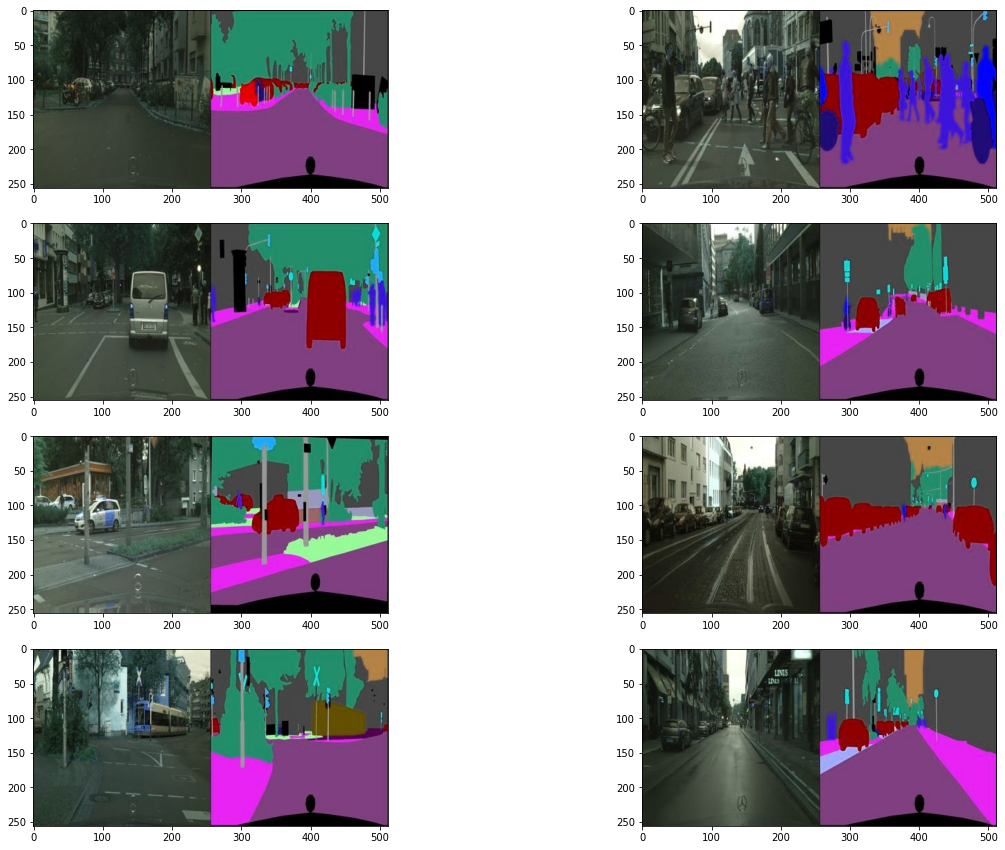

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 9):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(4,2,i)
    plt.imshow(img)

* 임의의 이미지 하나를 열어 크기를 확인한다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용할 수 있을 것으로 보인다.
* 아래 코드를 이용하여 이미지를 두 개로 나누도록 한다.

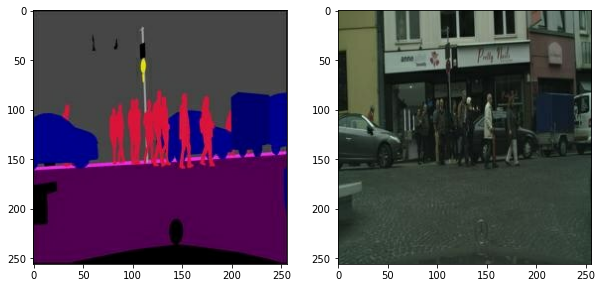

In [5]:
import tensorflow as tf

def normalize(x): # 이미지를 정규화하는 함수
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): # 시각화를 위해 이미지를 다시 복원하는 함수
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path): # 이미지를 로드한 수 shape의 width를 1/2한 값으로 분할
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    segment = img[:, w:, :] 
    segment = tf.cast(segment, tf.float32)
    city = img[:, :w, :] 
    city = tf.cast(city, tf.float32)
    return normalize(segment), normalize(city)

f = data_path + os.listdir(data_path)[1]
segment, city = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segment))
plt.subplot(1,2,2); plt.imshow(denormalize(city))

* Data Augmentation
  * 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 ```augmentation``` 방법을 적용하는 코드를 작성한다.
  * ```apply_augmentation``` 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용시킨다.

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segment, city):
    stacked = tf.concat([segment, city], axis=-1)
    # 1. 두 이미지가 채널 축으로 연결됨
    # 두 이미지가 각각 3채널인 경우 6채널이 됨
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 2. 1의 결과에서 각 50% 확률로 Reflection Padding 
    # 또는 Constant Padding이 30픽셀의 pad width만큼 적용됨

    out = image.random_crop(padded, size=[256, 256, 6])
    # 3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라냄
    
    out = image.random_flip_left_right(out)
    # 4. 3의 결과를 50% 확률로 가로로 뒤집음
    out = image.random_flip_up_down(out)
    # 5. 4의 결과를 50% 확률로 세로로 뒤집음
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
        # 6. 5의 결과를 50% 확률로 회전
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


* 바로 위에서 구성한 함수를 데이터에 적용해 시각화한다.

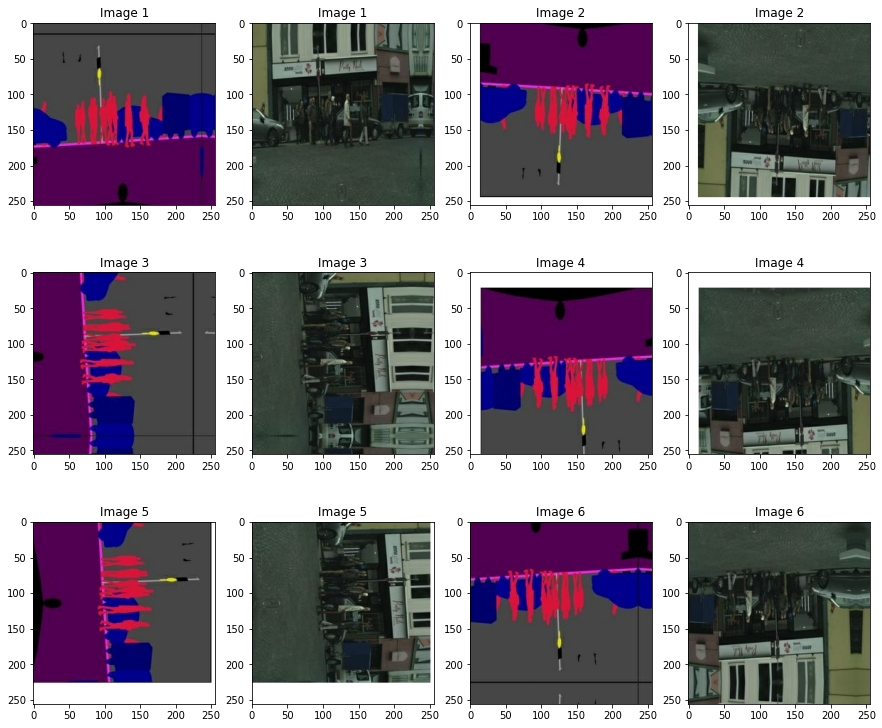

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = apply_augmentation(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city)); plt.title(f"Image {img_n}")
    img_n += 1

* 위 과정들을 학습 데이터에 적용하여, 잘 적용이 되었는지 하나의 이미지만 시각화하여 확인한다.

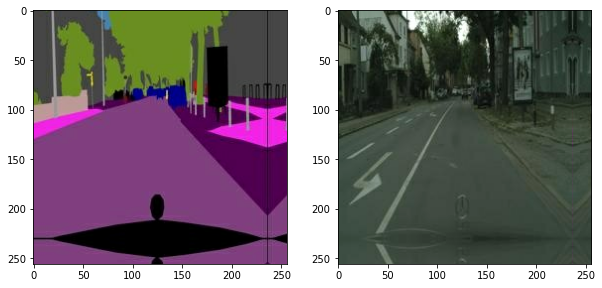

In [8]:
from tensorflow import data

def get_train(img_path):
    segment, city = load_img(img_path)
    segment, city = apply_augmentation(segment, city)
    return segment, city

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, city = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(city[0].astype(np.uint8))

-----

## 2. Generator 구성하기
* ```Generator```의 구성 요소
* 위의 정보들을 토대로 ```Generator```의 ```Encoder``` 부분을 구현
  * ```Convolution → BatchNorm → LeakyReLU```의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 생성
  * ```__init__()``` 메서드에서 ```n_filters```, ```use_bn```를 설정하여 사용할 필터의 개수와 ```BatchNorm``` 사용 여부를 결정
  * ```Convolution``` 레이어에서 필터의 크기(=4) 및 stride(=2)와 ```LeakyReLU``` 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


* 각 블록을 거치면서 사용할 필터의 개수를 ```filters```라는 리스트에 지정
* ```blocks```이라는 리스트에는 사용할 블록들을 정의
* ```call()``` 메서드에서 차례대로 블록들을 통과
* ```Encoder``` 첫 번째 블록에서는 ```BatchNorm```을 사용하지 않음

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* 레이어가 제대로 구성되었는지 확인하기 위한 용도로 ```get_summary```를 따로 생성

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인할 수 있다.

* ```Encoder```와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 ```Decoder``` 구현
* 처음 세 개의 블록에서만 ```Dropout```을 사용했으며, 마지막 ```convolution```에는 3개의 필터를 사용해 출력

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [13]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력

* ```tf.keras.Model```을 상속받아 ```Encoder```와 ```Decoder```를 연결해 ```Generator```를 구성

In [14]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


-----
## 3. Generator 재구성하기
<img src="https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g2.max-800x600.png"><br>
* 단순한 ```Encoder-Decoder``` 구조에 비해 ```Encoder```와 ```Decoder``` 사이를 ```skip connection```으로 연결한 ```U-Net``` 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보이고 있음
* 앞에서 구현한 ```Encoder-Decoder``` 구조를 조금 수정하여 ```U-Net``` 구조를 생성

In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


* 정의된 블록들을 이용해 한 번에 ```U-Net Generator```를 정의
  * ```__init__()``` 메서드에서 ```Encoder``` 및 ```Decoder```에서 사용할 모든 블록들을 정의
  * ```call()```에서 ```forward propagation```
  * ```skip connection```이 ```call()``` 내부에서 어떻게 구현되었는지 확인

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* ```__init__()``` 에서 정의된 ```encode_blocks``` 및 ```decode_blocks```가 ```call()``` 내부에서 차례대로 사용되어 ```Encoder``` 및 ```Decoder``` 내부 연산을 수행
  1. ```Encoder```와 ```Decoder``` 사이의 skip connection을 위해 ```features``` 라는 리스트를 생성
  2. ```Encoder``` 내에서 사용된 각 블록들의 출력을 차례대로 삽입
  3. ```Encoder```의 최종 출력이 ```Decoder```의 입력으로 들어가면서 다시 한번 각각의 ```Decoder``` 블록들을 통과
  4. ```features``` 리스트에 있는 각각의 출력들이 ```Decoder``` 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용
* ```U-Net``` 구조 ```Generator``` 내부의 각 출력이 적절한지 아래 코드로 확인

In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

```Encoder-Decoder Generator``` 구조에서 약 4천 만 개였던 학습 파라미터가 Skip connection을 추가한 ```U-Net Generator```에서는 5천 4백여 만 개로 증가함을 확인할 수 있음

-----

## 4. Discriminator 구성하기
* ```Discriminator```의 구성 요소
* ```Discriminator```에 사용할 기본적인 블록 생성
  * ```__init__()```에서 필요한 만큼 많은 설정이 가능하도록 함
    1. ```n_filters``` : 필터의 갯수
    2. ```stride``` : 필터가 순회하는 간격
    3. ```custom_pad``` : 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정
    4. ```use_bn``` : BatchNorm의 사용 여부
    5. ```act``` : 활성화 함수 사용 여

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()   # 패딩 레이어 통과
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
            # Convolution 레이어 통과
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None # BatchNormalization 레이어 통과
        self.lrelu = layers.LeakyReLU(0.2) if act else None # LeakyReLU 활성화 레이어 통과
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


* 각 출력의 크기가 맞는지 확인하는 코드를 작성

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* Discriminator 생성

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate() # 단순한 연결 수행(concat)
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid") # sigmoid 활성 함수를 사용하여 최종 출력 수행
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


* 각 블록의 출력 크기 확인

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력 시각화

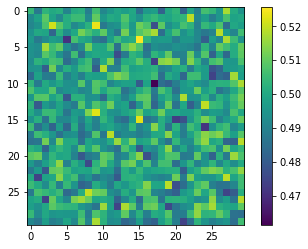

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

-----

## 5. 모델 학습
* 손실 함수 선택에 따른 결과의 차이
  <img src="https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_loss2.max-800x600.png"><br>
  * 일반적인 ```GAN```의 손실 함수에 ```L1```을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


* ```get_gene_loss``` : ```Generator```의 손실 함수, 총 3개의 입력
  * ```fake_disc``` : ```Generator```가 생성한 가짜 이미지를 ```Discriminator```에 입력하여 얻어진 값
  * 실제 이미지를 뜻하는 "1"과 비교하기 위해 ```tf.ones_like()```를 사용
  * L1 손실을 계산하기 위해 생성한 가짜 이미지(```fake_output```)와 실제 이미지(```real_output```) 사이의 ```MAE(Mean Absolute Error)```를 계산
* ```get_disc_loss``` : ```Discriminator```의 손실 함수, 총 2개의 입력
  * 가짜 및 진짜 이미지가 ```Discriminator```에 각각 입력되어 얻어진 값
  * 실제 이미지를 잘 구분해 내야 하므로 ```real_disc```는 "1"로 채워진 벡터와 비교하고, ```fake_disc```는 "0"으로 채워진 벡터와 비교



In [24]:
# 사용할 optimizer 구현

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정 구현

In [33]:
@tf.function
def train_step(segment, real_city):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_city = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_city, training=True)
        real_disc = discriminator(segment, real_city, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_city, real_city, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


* 위에서 정의한 함수를 이용하여 학습을 진행한다.

In [34]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8944                     
L1_loss:0.2109                     
Discriminator_loss:1.5309

EPOCH[1] - STEP[20]                     
Generator_loss:0.7292                     
L1_loss:0.2307                     
Discriminator_loss:1.5569

EPOCH[1] - STEP[30]                     
Generator_loss:0.7779                     
L1_loss:0.2690                     
Discriminator_loss:1.3685

EPOCH[1] - STEP[40]                     
Generator_loss:0.6770                     
L1_loss:0.2012                     
Discriminator_loss:1.3471

EPOCH[1] - STEP[50]                     
Generator_loss:0.7386                     
L1_loss:0.2263                     
Discriminator_loss:1.2255

EPOCH[1] - STEP[60]                     
Generator_loss:0.9469                     
L1_loss:0.1982                     
Discriminator_loss:1.2790

EPOCH[1] - STEP[70]                     
Generator_loss:0.8718                     
L1_loss:0.2045                    

-----

## 6. 모델 테스트 진행

In [27]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of test examples :", len(os.listdir(test_path)))

number of test examples : 5


(-0.5, 255.5, 255.5, -0.5)

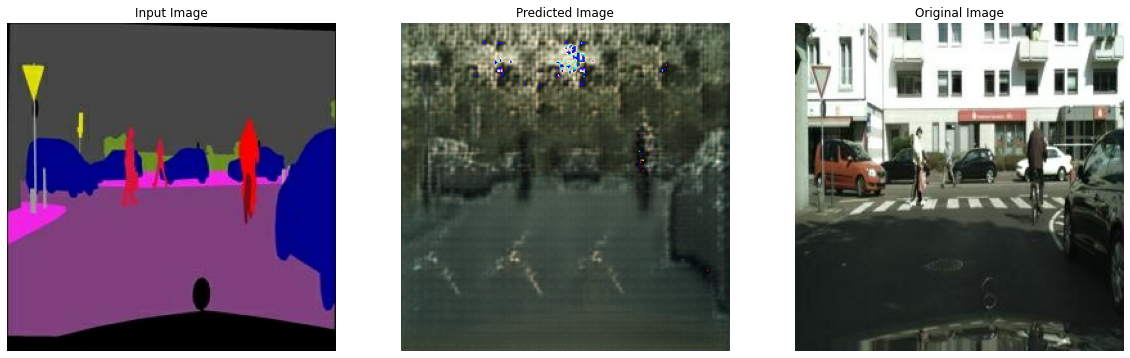

In [28]:
# 20 epoch

test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Original Image'); plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

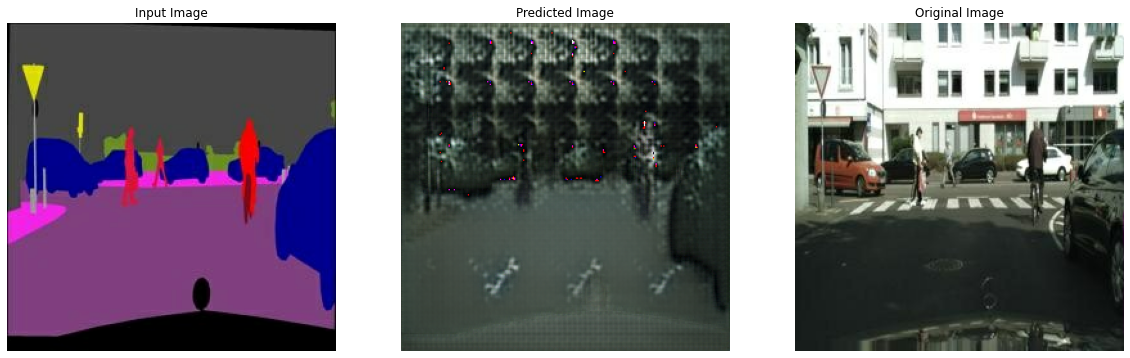

In [32]:
# 40 epoch

test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Original Image'); plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

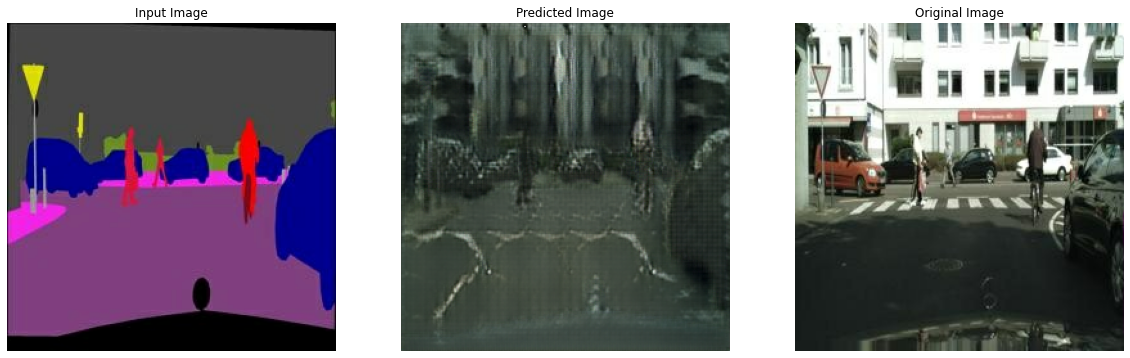

In [35]:
# 100 epoch

test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Original Image'); plt.axis('off')

-----

## 7. 마치며
* 예측한 이미지의 정확도를 맞추기 위해 epoch의 수를 높였으나 예측 이미지의 결과물이 만족스럽지 않았으며, 방식 역시 비효율적이라는 생각이 들었다. 더욱 효율적인 방식을 연구해야 할 필요가 있다고 느껴진다.